In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_excel('../dataset/1.배달 호출데이터 요약.xlsx', engine='openpyxl', sheet_name='배달호출정보 테이블명세서')
meta = pd.DataFrame(metadata[4:].values, columns=metadata[3:4].values[0])

data = pd.read_csv('../dataset/CATHOLIC_DATA.csv', header=None)
data.columns = meta['영문 컬럼명'].values[:-1]

bucheon = data[(data['DLVR_DSTN_SIGUNGU'] == '부천시') & (data['DLVR_REQUST_STTUS_VALUE'] == 1)]
print(bucheon.shape)

bucheon.head()

(1032409, 32)


,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_RECPT_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
7,163786,2019-07-15,C000077,1,C000077,S0021796,카페/디저트,4119011500,경기도,부천시,...,3000,200,17800,2,NaN,2019-07-15 11:32:29,2019-07-15 11:32:49,2019-07-15 11:40:39,2019-07-15 11:44:44,\N
8,163805,2019-07-15,C000077,1,C000077,S0021884,돈까스/일식,4119011500,경기도,부천시,...,3000,200,12000,1,승인:비씨카드사,2019-07-15 11:13:37,2019-07-15 11:14:02,2019-07-15 11:22:04,2019-07-15 11:28:24,\N
11,163895,2019-07-15,C000077,1,C000077,S0021739,치킨,4119011300,경기도,부천시,...,3000,200,29900,1,승인:KB국민카드,2019-07-15 11:29:06,2019-07-15 11:29:25,2019-07-15 11:39:54,2019-07-15 11:42:29,\N
12,163922,2019-07-15,C000077,1,C000077,S0021772,분식,4119011500,경기도,부천시,...,3000,200,14500,2,NaN,2019-07-15 11:35:22,2019-07-15 11:38:30,2019-07-15 11:48:10,2019-07-15 11:54:29,\N
13,163952,2019-07-15,C000077,1,C000077,S0021739,치킨,4119011300,경기도,부천시,...,3000,200,16000,1,승인:NH농협카드,2019-07-15 12:12:14,2019-07-15 12:27:17,2019-07-15 12:27:40,2019-07-15 12:30:54,\N


In [3]:
df = pd.DataFrame()

df['date'] = bucheon['PROCESS_DT']
df['food'] = bucheon['DLVR_STORE_INDUTY_NM']
df['dong'] = bucheon['DLVR_DSTN_DONG']
df['money'] = bucheon['GOODS_AMOUNT']

df['receipt'] = bucheon['DLVR_RCEPT_TIME']
df['dispatch'] = bucheon['DLVR_CARALC_TIME']
df['receive'] = bucheon['DLVR_RECPT_TIME']
df['done'] = bucheon['DLVR_COMPT_TIME']
df['cancle'] = bucheon['DLVR_CANCL_TIME']

- 배달배차시간과 배달수령시간이 없는 데이터 제외 (아마도 포장일듯)

In [4]:
df = df[(df['receive'] != '\\N') & (df['dispatch'] != '\\N')]

In [5]:
def get_time(x):
    h, m, s = x.split()[1].split(':')
    return int(h)*3600 + int(m)*60 + int(s)

def get_hour(x):
    return pd.Timestamp(x.split(' ')[1]).time().hour

days = ['월','화','수','목','금','토','일']

def get_week(x):
    d = pd.Timestamp(x)
    return days[datetime.date(d.year, d.month, d.day).weekday()]

def is_holiday(x):
    if x == '월' or '화' or '수' or '목' or '금':
        return 0
    elif x == '토' or '일':
        return 1

In [6]:
df['confirm_time'] = abs(df['dispatch'].map(lambda x: get_time(x)) - df['receipt'].map(lambda x: get_time(x)))
df['cook_time'] = abs(df['receive'].map(lambda x: get_time(x)) - df['dispatch'].map(lambda x: get_time(x)))
df['delivery_time'] = abs(df['done'].map(lambda x: get_time(x)) - df['receive'].map(lambda x: get_time(x)))
df['done_time'] = abs(df['done'].map(lambda x: get_time(x)) - df['receipt'].map(lambda x: get_time(x)))

df['hour'] = bucheon['DLVR_RCEPT_TIME'].map(lambda x: get_hour(x))
df['week'] = bucheon['DLVR_RCEPT_TIME'].map(lambda x: get_week(x))
df['holiday'] = df['week'].map(lambda x: is_holiday(x))

df.head()

,date,food,dong,money,receipt,dispatch,receive,done,cancle,confirm_time,cook_time,delivery_time,done_time,hour,week,holiday
7,2019-07-15,카페/디저트,범박동,17800,2019-07-15 11:32:29,2019-07-15 11:32:49,2019-07-15 11:40:39,2019-07-15 11:44:44,\N,20,470,245,735,11,월,0
8,2019-07-15,돈까스/일식,옥길동,12000,2019-07-15 11:13:37,2019-07-15 11:14:02,2019-07-15 11:22:04,2019-07-15 11:28:24,\N,25,482,380,887,11,월,0
11,2019-07-15,치킨,소사본동,29900,2019-07-15 11:29:06,2019-07-15 11:29:25,2019-07-15 11:39:54,2019-07-15 11:42:29,\N,19,629,155,803,11,월,0
12,2019-07-15,분식,옥길동,14500,2019-07-15 11:35:22,2019-07-15 11:38:30,2019-07-15 11:48:10,2019-07-15 11:54:29,\N,188,580,379,1147,11,월,0
13,2019-07-15,치킨,소사본동,16000,2019-07-15 12:12:14,2019-07-15 12:27:17,2019-07-15 12:27:40,2019-07-15 12:30:54,\N,903,23,194,1120,12,월,0


- 배달시간이 1분 이하, 2시간(7200초) 이상이면 결측값으로 판단하고 제외한다

In [7]:
df = df[(df['delivery_time']>= 60) & (df['delivery_time'] <= 7200)]

# 딥러닝

In [53]:
import keras
from tensorflow.keras.utils impor
t to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## 변수 인코딩

In [176]:
food_ord = {'카페/디저트':0, '돈까스/일식':1, '치킨':2, '분식':3, '패스트푸드':4,
            '족발/보쌈':5, '찜탕':6, '한식':7, '중식':8, '아시안/양식':9,
            '도시락':10, '피자':11, '회':12, '배달전문업체':13, '야식':14}

df['food_ord'] = df.food.map(food_ord)

In [177]:
X = df[['dong', 'hour', 'week', 'money', 'cook_time', 'delivery_time']]
y = df['food_ord']

X = pd.get_dummies(X)
X = X.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

## 스케일링

In [178]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

## 모델 훈련

In [179]:
keras.backend.clear_session()

model = keras.models.Sequential()

model.add(keras.layers.Dense(15, input_shape=(None, 35), activation='relu'))
model.add(keras.layers.Dense(15, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [180]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 15)          540       
_________________________________________________________________
dense_1 (Dense)              (None, None, 15)          240       
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________


In [181]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    #batch_size=512,
                    validation_data=(X_val, y_val))

Epoch 1/30
11802/11802 [==============================] - 36s 3ms/step - loss: 2.3086 - accuracy: 0.2560 - val_loss: 2.2534 - val_accuracy: 0.2749
Epoch 2/30
11802/11802 [==============================] - 35s 3ms/step - loss: 2.2333 - accuracy: 0.2760 - val_loss: 2.2653 - val_accuracy: 0.2759
Epoch 3/30
11802/11802 [==============================] - 36s 3ms/step - loss: 2.2140 - accuracy: 0.2853 - val_loss: 2.2788 - val_accuracy: 0.2701
Epoch 4/30
11802/11802 [==============================] - 36s 3ms/step - loss: 2.2027 - accuracy: 0.2920 - val_loss: 2.2630 - val_accuracy: 0.2789
Epoch 5/30
11802/11802 [==============================] - 36s 3ms/step - loss: 2.1948 - accuracy: 0.2937 - val_loss: 2.2598 - val_accuracy: 0.2758
Epoch 6/30
11802/11802 [==============================] - 35s 3ms/step - loss: 2.1898 - accuracy: 0.2949 - val_loss: 2.2882 - val_accuracy: 0.2699
Epoch 7/30
11802/11802 [==============================] - 36s 3ms/step - loss: 2.1853 - accuracy: 0.2962 - val_loss: 2

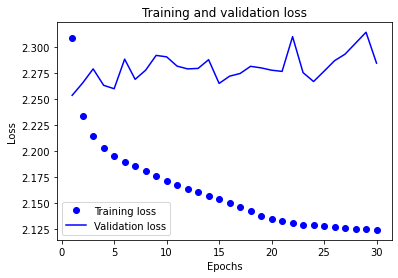

In [182]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

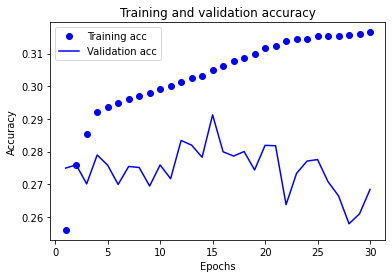

In [183]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [184]:
test_pred = model.predict(X_test)
test_pred_cl = model.predict_classes(X_test)

In [185]:
# classification report
print(classification_report(y_test, test_pred_cl))

              precision    recall  f1-score   support

           0       0.48      0.03      0.05     19768
           1       0.18      0.14      0.16     17139
           2       0.34      0.59      0.44     57233
           3       0.31      0.09      0.14     25876
           4       0.24      0.03      0.06      8057
           5       0.17      0.68      0.28     16067
           6       0.13      0.01      0.02      9258
           7       0.26      0.29      0.27     35284
           8       0.18      0.04      0.07      9061
           9       0.00      0.00      0.00      5547
          10       0.27      0.14      0.18      3160
          11       0.17      0.02      0.04     10168
          12       0.21      0.08      0.11      3700
          13       0.00      0.00      0.00      4939
          14       0.00      0.00      0.00      5962

    accuracy                           0.27    231219
   macro avg       0.20      0.14      0.12    231219
weighted avg       0.26   

In [186]:
print(accuracy_score(y_test, test_pred_cl))

0.2684381473840818


### 요리시간 빼고

In [174]:
X = df[['dong', 'hour', 'week', 'money', 'delivery_time']]
y = df['food_ord']

X = pd.get_dummies(X)
X = X.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

keras.backend.clear_session()

model = keras.models.Sequential()

model.add(keras.layers.Dense(15, input_shape=(None, 34), activation='relu'))
model.add(keras.layers.Dense(15, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    #batch_size=512,
                    validation_data=(X_val, y_val))

Epoch 1/40
11802/11802 [==============================] - 36s 3ms/step - loss: 2.3078 - accuracy: 0.2562 - val_loss: 2.2590 - val_accuracy: 0.2735
Epoch 2/40
11802/11802 [==============================] - 35s 3ms/step - loss: 2.2306 - accuracy: 0.2787 - val_loss: 2.2180 - val_accuracy: 0.2892
Epoch 3/40
11802/11802 [==============================] - 36s 3ms/step - loss: 2.1998 - accuracy: 0.2912 - val_loss: 2.1977 - val_accuracy: 0.2964
Epoch 4/40
11802/11802 [==============================] - 35s 3ms/step - loss: 2.1898 - accuracy: 0.2935 - val_loss: 2.1941 - val_accuracy: 0.2969
Epoch 5/40
11802/11802 [==============================] - 36s 3ms/step - loss: 2.1870 - accuracy: 0.2949 - val_loss: 2.1933 - val_accuracy: 0.2978
Epoch 6/40
11802/11802 [==============================] - 36s 3ms/step - loss: 2.1854 - accuracy: 0.2952 - val_loss: 2.1935 - val_accuracy: 0.3001
Epoch 7/40
11802/11802 [==============================] - 36s 3ms/step - loss: 2.1840 - accuracy: 0.2959 - val_loss: 2

In [175]:
test_pred = model.predict(X_test)
test_pred_cl = model.predict_classes(X_test)
print(accuracy_score(y_test, test_pred_cl))

0.31218887721164784


## k겹 교차검증

In [207]:
X = df[['dong', 'hour', 'week', 'money', 'delivery_time']]
y = df['food_ord']

X = pd.get_dummies(X)
X = X.reset_index(drop=True)

train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=0.3)

train_targets = to_categorical(train_targets)

In [211]:
from keras import models
from keras import layers

def build_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(15, input_shape=(None, 34), activation='relu'))
    model.add(keras.layers.Dense(15, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
    return model

In [ ]:
k = 5

num_val_samples = len(train_data) // k
num_epochs = 10
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1


In [210]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드#', i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

SyntaxError: keyword can't be an expression (<ipython-input-210-26bfcea29015>, line 20)

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_histroy[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 중동만 예측
- "중동에서는" 몇시, 무슨요일, 얼마를 가지고, 얼마의 배달시간을 원한다면 무슨 음식을 먹을 수 있을까?

In [187]:
j = df[df['dong'] == '중동']

food_ord = {'카페/디저트':0, '돈까스/일식':1, '치킨':2, '분식':3, '패스트푸드':4,
            '족발/보쌈':5, '찜탕':6, '한식':7, '중식':8, '아시안/양식':9,
            '도시락':10, '피자':11, '회':12, '배달전문업체':13, '야식':14}

j['food_ord'] = j.food.map(food_ord)

In [188]:
X = j[['hour', 'week', 'money', 'cook_time', 'delivery_time']]
y = j['food_ord']

X = pd.get_dummies(X)
X = X.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [189]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [194]:
keras.backend.clear_session()

model = keras.models.Sequential()

model.add(keras.layers.Dense(15, input_shape=(None, 11), activation='softmax'))
model.add(keras.layers.Dense(15, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [195]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 15)          180       
_________________________________________________________________
dense_1 (Dense)              (None, None, 15)          240       
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________


In [196]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    #batch_size=512,
                    validation_data=(X_val, y_val))

Epoch 1/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.3490 - accuracy: 0.2453 - val_loss: 2.3162 - val_accuracy: 0.2430
Epoch 2/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.2991 - accuracy: 0.2441 - val_loss: 2.3200 - val_accuracy: 0.2430
Epoch 3/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.2944 - accuracy: 0.2405 - val_loss: 2.3293 - val_accuracy: 0.2430
Epoch 4/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.2885 - accuracy: 0.2575 - val_loss: 2.3526 - val_accuracy: 0.2430
Epoch 5/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.2818 - accuracy: 0.2709 - val_loss: 2.3970 - val_accuracy: 0.2430
Epoch 6/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.2746 - accuracy: 0.2751 - val_loss: 2.4708 - val_accuracy: 0.1027
Epoch 7/30
2165/2165 [==============================] - 7s 3ms/step - loss: 2.2662 - accuracy: 0.2779 - val_loss: 2.5770 - val_accuracy:

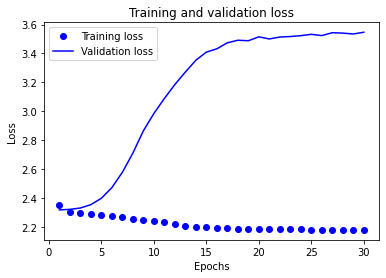

In [197]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

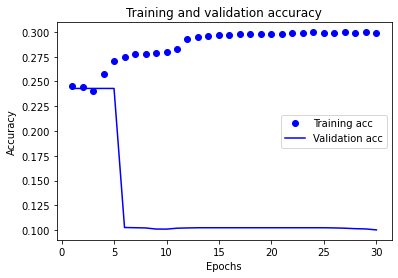

In [198]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [199]:
test_pred = model.predict(X_test)
test_pred_cl = model.predict_classes(X_test)

In [200]:
print(accuracy_score(y_test, test_pred_cl))

0.2957819536462877


In [201]:
from sklearn.linear_model import LogisticRegression

In [203]:
X = df[['dong', 'hour', 'week', 'money', 'delivery_time']]
y = df['food_ord']

X = pd.get_dummies(X)
X = X.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

log_reg = LogisticRegression().fit(X_train, y_train)

print("학습 집합 정확도: {:.3f}".format(log_reg.score(X_train, y_train)))
print("테스트 집합 정확도: {:.3f}".format(log_reg.score(X_test, y_test)))

학습 집합 정확도: 0.247
테스트 집합 정확도: 0.247
